In [69]:
import glob
import sys 

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import higher

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.display import display

sys.path.append("../src")
from evaluate import evalSingleEdits
import utils
from utils import retrieveDataloader


matplotlib.rcParams['figure.figsize'] = (6, 4)

In [6]:
class ModelComps:
    def __init__(self, model_name, base_name, archive=False, test=False):
        
        self.test = test
        self.archive = archive
        self.model_name = model_name
        self.base_name = base_name
        self.ots_name = "OTS"
        self.models = {}
        self.modelStats = self.getModelParams()
        
        self.stats = {}
    
    
    def getModelParams(self):
        model_id = ".".join(self.model_name.split(".")[1:])
        return pd.Series(torch.load(f"../models/hypers.{model_id}")).to_frame().T
        

    def readData(self, model_name, kind='model'):
        if self.archive:
            eval_glob = glob.glob(f"./archive/*{model_name}")
        elif self.test:
            eval_glob = glob.glob(f"./test/*{model_name}")
        else:
            eval_glob = glob.glob(f"./*{model_name}")
        for evaluation in eval_glob:
            df = pd.read_csv(evaluation)
            eval_id = f"{kind}_{evaluation.split('.')[4].split('_')[0]}"
            self.models[eval_id] = df
    
    def runStats(self):
        if not self.models:
            self.readData(self.base_name, kind='base')
            self.readData(self.model_name)
            self.readData(self.ots_name, kind='ots')
            
        for name, model in self.models.items():  
            mean_new_ppl = model.new_ppl.mean() 
            mean_orig_ppl = model.orig_ppl.mean() 
            pct_ppl_dd = model.apply(lambda x: 100*(x.new_ppl - x.orig_ppl)/x.orig_ppl, axis=1).mean()
            gross_ppl_dd = model.apply(lambda x: x.new_ppl - x.orig_ppl, axis=1).mean()
            new_logits_higher = model.success.mean()
            new_logits_higher05 = model.apply(lambda x: x.new_logits > 0.95*x.orig_logits,axis=1).mean()
            new_logits_higher10 = model.apply(lambda x: x.new_logits > 0.90*x.orig_logits,axis=1).mean()

            success_by_probs = model.apply(lambda x: x.new_prob > x.old_prob, axis=1).mean()
            n_edit_steps = model.n_edit_steps.max()

            
            self.stats[name] = {
                "edit_steps":n_edit_steps,
                "mean_new_ppl":mean_new_ppl,
                "mean_orig_ppl":mean_orig_ppl,
                "pct_ppl_dd":pct_ppl_dd,
                "gross_ppl_dd":gross_ppl_dd,
                "new_logits_higher":new_logits_higher,
                "new_logits_higher05":new_logits_higher05,
                "new_logits_higher10":new_logits_higher10,
                "success_by_probs":success_by_probs,
            }
    
    @property
    def statDf(self):
        stats_df = (
            pd.DataFrame(self.stats).T
            .reset_index()
            .rename(columns={'index':'model'})
            .sort_values(["model", "edit_steps"], ascending=False)
        )
        
        return stats_df
    
    def summary(self):
        if not self.stats:
            self.runStats()
        print("Model Parameters:")
        display(self.modelStats)
        
        print("Success Metrics")
        stats_df = (
            pd.DataFrame(self.stats).T
            .reset_index()
            .rename(columns={'index':'model'})
            .sort_values(["model", "edit_steps"], ascending=False)
        )
        
        display(stats_df)
        
    
    def runEvaluation(self, n_edit_steps=[1], ots=False, baseline=False):
        
        model_path = f"../models/{self.model_name}"
        model, tokenizer = utils.loadTrainedModel(model_path)
        dataloader = retrieveDataloader(
            tokenizer, bs=1, dataset='valid', max_obs=500
        )

        for nes in n_edit_steps:
            _, _ = evalSingleEdits(
                model, 
                dataloader, 
                model_path, 
                int(nes)
                )
            if baseline:
                base_path = f"../models/finetune/{self.baseline}"
                model_baseline, _ = utils.loadTrainedModel(base_path)
                _, _ = evalSingleEdits(
                    model_baseline, 
                    dataloader, 
                    base_path, 
                    int(nes)
                    )
            if ots:
                model_ots, _ = utils.loadOTSModel()
                _, _ = evalSingleEdits(
                    model_ots, 
                    dataloader, 
                    "OTS", 
                    int(nes)
                    )
                
    def plotter(self, xlim=[]):
        print("Plotting Logits")
        for name, model in self.models.items():
            print(name)

            plt.hist(model.orig_logits, alpha=0.4, label="Pre-Edit")
            plt.hist(model.new_logits, alpha=0.4, label="Post-Edit")
            if name[:3] == 'ots':
                plt.legend(fontsize='large')
            
            if xlim:
                plt.xlim(xlim)
            plt.xlabel("Edited Entity Logits", fontsize='large')
            plt.ylabel("", fontsize='large')
            plt.show()

       
        print("Plotting % Logit Diffs")
        for name, model in self.models.items():
            try:
                plt.hist(abs(model.orig_logits - model.new_logits) / abs(model.orig_logits), alpha=0.5, label=name, bins=20)
            except:
                continue
        plt.legend()
        plt.show()



In [136]:
!ls -lt ./test

total 40
-rw-rw-r-- 1 spencerbraun spencerbraun  2010 Mar 17 03:59 edit_success_20210317.03.03.1615952799_gpt2_epoch0_ts10000.20210310.18.03.1615401990
-rw-rw-r-- 1 spencerbraun spencerbraun 29581 Mar 17 03:46 edit_success_20210317.00.03.1615941304_model_epoch0_ts10000.20210314.16.03.1615740151
drwxrwxr-x 2 spencerbraun spencerbraun  4096 Mar 17 00:34 archive


In [139]:
test = pd.read_csv("test/edit_success_20210317.00.03.1615941304_model_epoch0_ts10000.20210314.16.03.1615740151")

In [145]:
test.iloc[:100].success.mean()

0.89

In [7]:
comps_test = ModelComps(
    model_name="model_epoch0_ts10000.20210314.16.03.1615740151",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    test=True
)

comps_test.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,10.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
1,model_1615941304,1.0,61.689550,61.170151,0.849105,0.519399,0.840000,0.625,0.365,0.940000
0,base_1615952799,1.0,41.700817,41.658672,0.101167,0.042145,0.769231,0.000,0.000,0.846154


Plotting Logits
base_1615952799


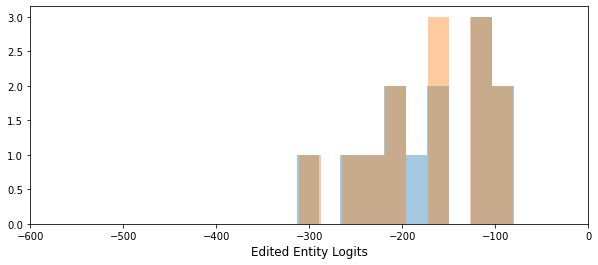

model_1615941304


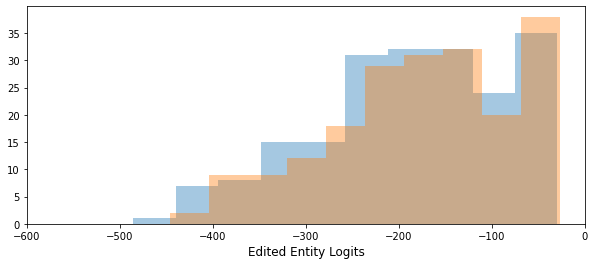

Plotting % Logit Diffs


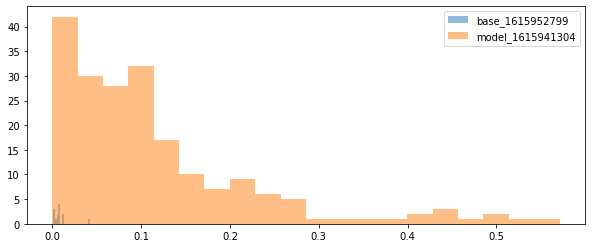

In [8]:
matplotlib.rcParams['figure.figsize'] = (10, 4)
comps_test.plotter([-600,0])


# model_epoch0_ts10000.20210314.16.03.1615740151
## cedit=1, cloc=10, 10k steps
Notes: Model run morning of 3/14, showed best performance to date.

In [9]:
comps = ModelComps(
    model_name="model_epoch0_ts10000.20210314.16.03.1615740151",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,10.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
7,ots_1615826715,5.0,92.249127,90.703072,1.704523,1.546055,0.72,0.16,0.04,0.86
8,ots_1615826291,3.0,91.357340,90.703072,0.721330,0.654268,0.78,0.08,0.02,0.86
6,ots_1615825880,1.0,90.831759,90.703072,0.141878,0.128688,0.80,0.00,0.00,0.86
3,model_1615825376,5.0,89.211466,77.696777,14.820034,11.514689,0.82,0.58,0.46,0.92
4,model_1615822571,3.0,84.700869,77.696777,9.014649,7.004092,0.82,0.58,0.42,0.94
5,model_1615822038,1.0,78.251560,77.696777,0.714036,0.554783,0.84,0.56,0.40,0.92
2,base_1615828169,5.0,50.140138,49.353867,1.593129,0.786271,0.82,0.16,0.04,0.88
1,base_1615827722,3.0,49.605848,49.353867,0.510561,0.251981,0.84,0.08,0.00,0.88
0,base_1615827264,1.0,49.365100,49.353867,0.022761,0.011233,0.82,0.00,0.00,0.92


Plotting Logits
base_1615827264


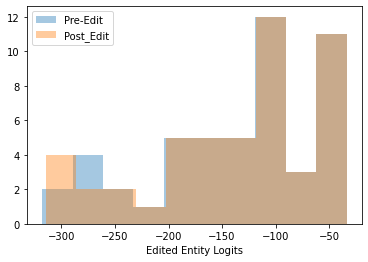

base_1615827722


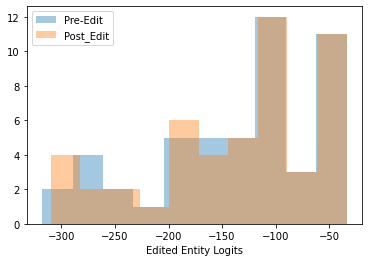

base_1615828169


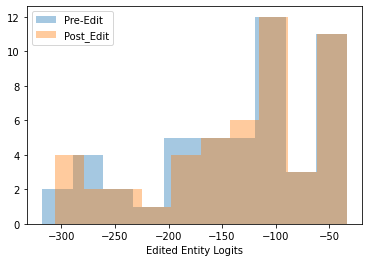

model_1615825376


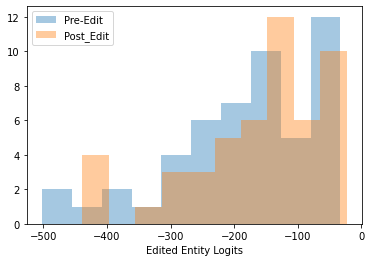

model_1615822571


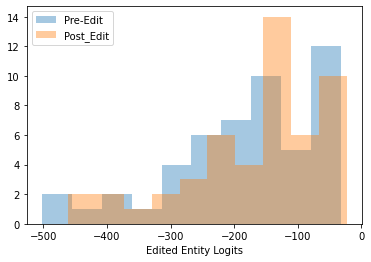

model_1615822038


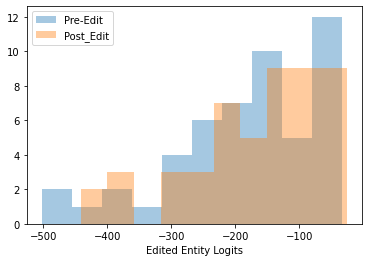

ots_1615825880


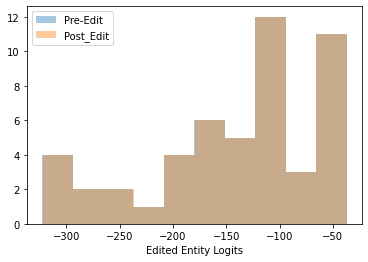

ots_1615826715


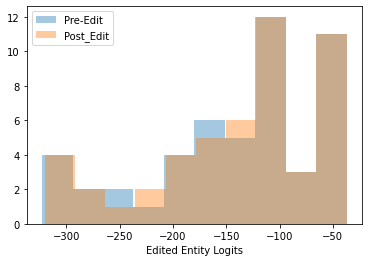

ots_1615826291


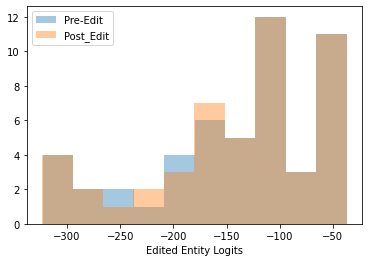

Plotting % Logit Diffs


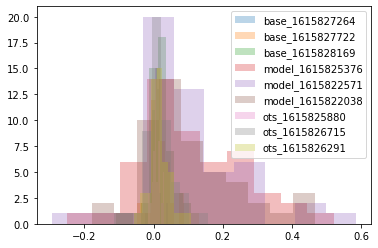

In [14]:
comps.plotter()

# model_epoch0_ts6000.20210314.16.03.1615740151
## cedit=1, cloc=10, 6k steps
Notes: same model, checking to see if evaluating an earlier checkpoint might be better. Tried with a number of checkpoints, generally worse

In [50]:
comps1 = ModelComps(
    model_name="model_epoch0_ts6000.20210314.16.03.1615740151",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps1.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,10.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
7,ots_1615826715,5.0,92.249127,90.703072,1.704523,1.546055,0.72,0.16,0.04,0.86
8,ots_1615826291,3.0,91.357340,90.703072,0.721330,0.654268,0.78,0.08,0.02,0.86
6,ots_1615825880,1.0,90.831759,90.703072,0.141878,0.128688,0.80,0.00,0.00,0.86
3,model_1615835384,5.0,103.998292,85.292526,21.931307,18.705765,0.86,0.70,0.52,0.90
4,model_1615834972,3.0,102.605914,85.292526,20.298834,17.313388,0.80,0.64,0.50,0.92
5,model_1615834590,1.0,85.984239,85.292526,0.810988,0.691712,0.88,0.64,0.36,0.94
2,base_1615828169,5.0,50.140138,49.353867,1.593129,0.786271,0.82,0.16,0.04,0.88
1,base_1615827722,3.0,49.605848,49.353867,0.510561,0.251981,0.84,0.08,0.00,0.88
0,base_1615827264,1.0,49.365100,49.353867,0.022761,0.011233,0.82,0.00,0.00,0.92


# model_epoch0_ts18000.20210315.00.03.1615768579
## cedit=1, cloc=10, 18k steps
Notes: Tried running model for many more steps to see if additional performance could be gained

In [51]:
comps2 = ModelComps(
    model_name="model_epoch0_ts18000.20210315.00.03.1615768579",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps2.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,10.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
7,ots_1615826715,5.0,92.249127,90.703072,1.704523,1.546055,0.72,0.16,0.04,0.86
8,ots_1615826291,3.0,91.357340,90.703072,0.721330,0.654268,0.78,0.08,0.02,0.86
6,ots_1615825880,1.0,90.831759,90.703072,0.141878,0.128688,0.80,0.00,0.00,0.86
5,model_1615829457,5.0,87.205313,75.677681,15.232539,11.527632,0.68,0.60,0.46,0.92
3,model_1615829048,3.0,83.930170,75.677681,10.904785,8.252489,0.64,0.50,0.36,0.94
4,model_1615828661,1.0,76.592660,75.677681,1.209047,0.914979,0.66,0.52,0.40,0.94
2,base_1615828169,5.0,50.140138,49.353867,1.593129,0.786271,0.82,0.16,0.04,0.88
1,base_1615827722,3.0,49.605848,49.353867,0.510561,0.251981,0.84,0.08,0.00,0.88
0,base_1615827264,1.0,49.365100,49.353867,0.022761,0.011233,0.82,0.00,0.00,0.92


Plotting Logits
base_1615827264


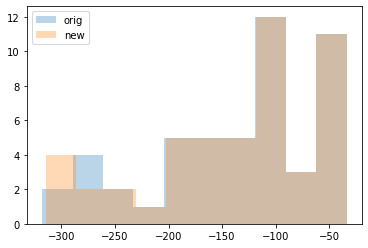

base_1615827722


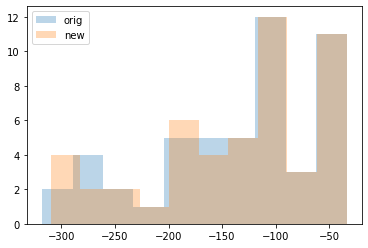

base_1615828169


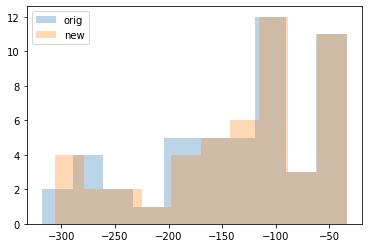

model_1615829048


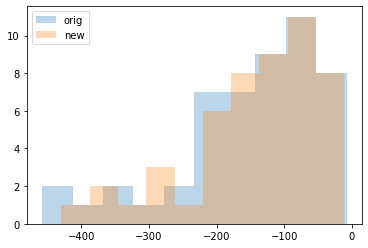

model_1615828661


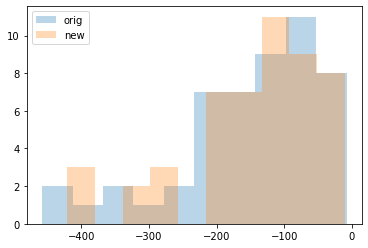

model_1615829457


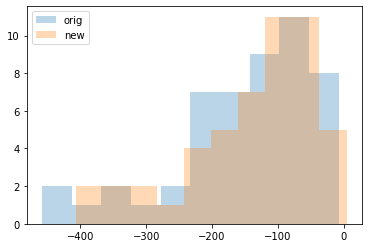

ots_1615825880


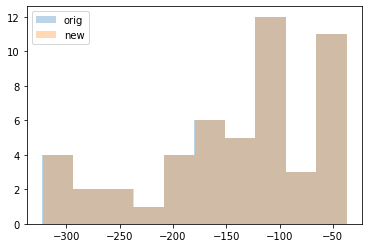

ots_1615826715


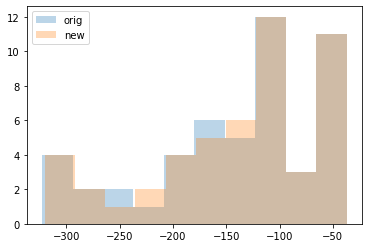

ots_1615826291


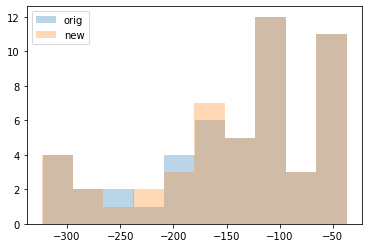

Plotting % Logit Diffs


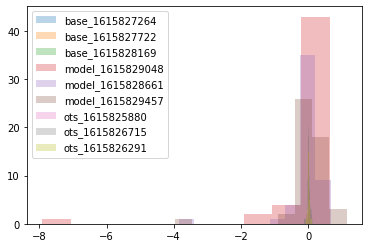

In [52]:
comps2.plotter()

# model_epoch0_ts10000.20210314.22.03.1615760445
## cedit=1, cloc=15, 10k steps


In [53]:
comps3 = ModelComps(
    model_name="model_epoch0_ts10000.20210314.22.03.1615760445",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps3.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,15.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
7,ots_1615826715,5.0,92.249127,90.703072,1.704523,1.546055,0.72,0.16,0.04,0.86
8,ots_1615826291,3.0,91.357340,90.703072,0.721330,0.654268,0.78,0.08,0.02,0.86
6,ots_1615825880,1.0,90.831759,90.703072,0.141878,0.128688,0.80,0.00,0.00,0.86
4,model_1615830698,5.0,92.998480,80.843575,15.035091,12.154905,0.86,0.60,0.48,0.92
3,model_1615830286,3.0,86.252994,80.843575,6.691217,5.409419,0.76,0.62,0.50,0.92
5,model_1615829897,1.0,80.696640,80.843575,-0.181751,-0.146934,0.74,0.54,0.44,0.94
2,base_1615828169,5.0,50.140138,49.353867,1.593129,0.786271,0.82,0.16,0.04,0.88
1,base_1615827722,3.0,49.605848,49.353867,0.510561,0.251981,0.84,0.08,0.00,0.88
0,base_1615827264,1.0,49.365100,49.353867,0.022761,0.011233,0.82,0.00,0.00,0.92


Plotting Logits
base_1615827264


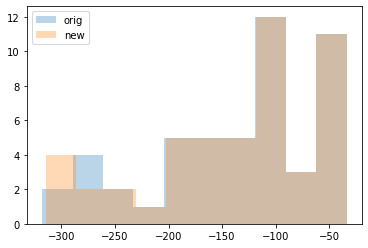

base_1615827722


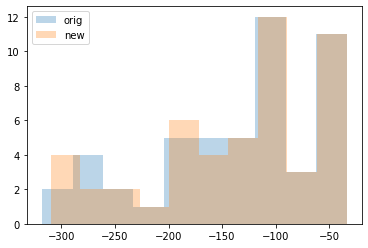

base_1615828169


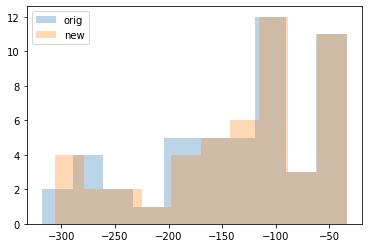

model_1615830286


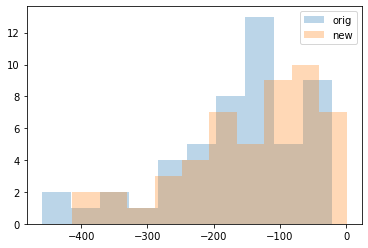

model_1615830698


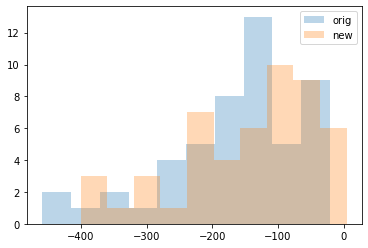

model_1615829897


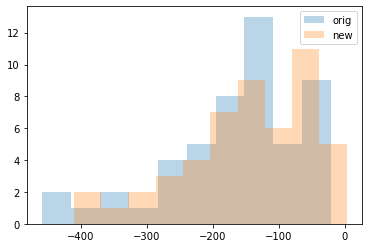

ots_1615825880


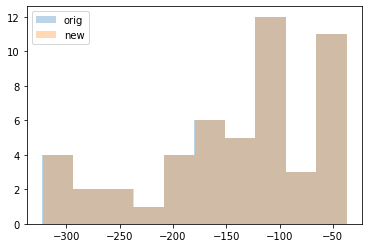

ots_1615826715


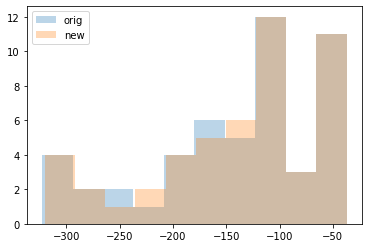

ots_1615826291


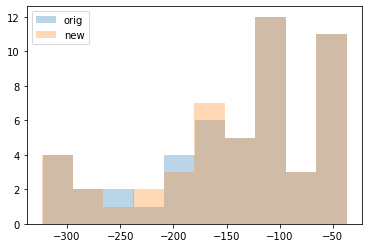

Plotting % Logit Diffs


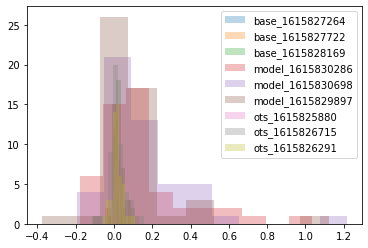

In [54]:
comps3.plotter()

# model_epoch0_ts10000.20210312.21.03.1615586239
## cedit=1, cloc=1, 10k steps
Notes: Model run Friday 3/12, first try with editing loss calculated just on the modified tokens. Has worse statistics

In [55]:
comps = ModelComps(
    model_name="model_epoch0_ts10000.20210312.21.03.1615586239",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps.summary()

Model Parameters:


,inner_lr,outer_lr,n_edit_steps,cedit,cloc
0,0.001,0.00001,1.0,1.0,1.0


Success Metrics


,model,edit_steps,mean_new_ppl,mean_orig_ppl,pct_ppl_dd,gross_ppl_dd,new_logits_higher,new_logits_higher05,new_logits_higher10,success_by_probs
7,ots_1615826715,5.0,92.249127,90.703072,1.704523,1.546055,0.72,0.16,0.04,0.86
8,ots_1615826291,3.0,91.357340,90.703072,0.721330,0.654268,0.78,0.08,0.02,0.86
6,ots_1615825880,1.0,90.831759,90.703072,0.141878,0.128688,0.80,0.00,0.00,0.86
3,model_1615833209,5.0,184.372973,94.858231,94.366869,89.514742,0.90,0.70,0.58,0.92
5,model_1615832802,3.0,162.421238,94.858231,71.225245,67.563007,0.90,0.70,0.56,0.94
4,model_1615832420,1.0,137.337339,94.858231,44.781679,42.479109,0.86,0.72,0.56,0.92
2,base_1615828169,5.0,50.140138,49.353867,1.593129,0.786271,0.82,0.16,0.04,0.88
1,base_1615827722,3.0,49.605848,49.353867,0.510561,0.251981,0.84,0.08,0.00,0.88
0,base_1615827264,1.0,49.365100,49.353867,0.022761,0.011233,0.82,0.00,0.00,0.92


In [ ]:
comps = ModelComps(
    model_name="model_epoch0_ts10000.20210312.21.03.1615586239",
    base_name="gpt2_epoch0_ts10000.20210310.18.03.1615401990",
    archive=False
)

comps.summary()

In [12]:
import utils
import copy

In [10]:
model, tokenizer = utils.loadOTSModel()

In [13]:
fmodel = copy.deepcopy(model)

In [14]:
model.load_state_dict(torch.load("model_examination"))

<All keys matched successfully>

In [15]:
fmodel.load_state_dict(torch.load("fmodel_examination"))

<All keys matched successfully>

In [58]:
len("transformer.h.3")

15

In [62]:
change_map = {}
for (p_name, p_), fp in zip(model.named_parameters(), fmodel.parameters()):
    if p_name[:15] in [f"transformer.h.{i}" for i in range(3,6)]:
        print(p_name)
        pct_change = (torch.linalg.norm(p_) - torch.linalg.norm(fp)) / torch.linalg.norm(p_)
        change_map[p_name] = pct_change.item()

transformer.h.3.ln_1.weight
transformer.h.3.ln_1.bias
transformer.h.3.attn.c_attn.weight
transformer.h.3.attn.c_attn.bias
transformer.h.3.attn.c_proj.weight
transformer.h.3.attn.c_proj.bias
transformer.h.3.ln_2.weight
transformer.h.3.ln_2.bias
transformer.h.3.mlp.c_fc.weight
transformer.h.3.mlp.c_fc.bias
transformer.h.3.mlp.c_proj.weight
transformer.h.3.mlp.c_proj.bias
transformer.h.4.ln_1.weight
transformer.h.4.ln_1.bias
transformer.h.4.attn.c_attn.weight
transformer.h.4.attn.c_attn.bias
transformer.h.4.attn.c_proj.weight
transformer.h.4.attn.c_proj.bias
transformer.h.4.ln_2.weight
transformer.h.4.ln_2.bias
transformer.h.4.mlp.c_fc.weight
transformer.h.4.mlp.c_fc.bias
transformer.h.4.mlp.c_proj.weight
transformer.h.4.mlp.c_proj.bias
transformer.h.5.ln_1.weight
transformer.h.5.ln_1.bias
transformer.h.5.attn.c_attn.weight
transformer.h.5.attn.c_attn.bias
transformer.h.5.attn.c_proj.weight
transformer.h.5.attn.c_proj.bias
transformer.h.5.ln_2.weight
transformer.h.5.ln_2.bias
transformer.

In [43]:
change_map

{'transformer.h.3.ln_1.weight': 7.644336437806487e-05,
 'transformer.h.3.ln_1.bias': -0.0018237857148051262,
 'transformer.h.3.attn.c_proj.bias': 0.00017843444948084652,
 'transformer.h.3.ln_2.weight': -1.5738794900244102e-05,
 'transformer.h.3.ln_2.bias': -0.0020129350014030933,
 'transformer.h.3.mlp.c_fc.bias': -1.2387055903673172e-05,
 'transformer.h.3.mlp.c_proj.bias': -5.463205525302328e-06,
 'transformer.h.4.ln_1.weight': -1.7144548110081814e-05,
 'transformer.h.4.ln_1.bias': -0.002272357465699315,
 'transformer.h.4.attn.c_proj.bias': 8.524410077370703e-06,
 'transformer.h.4.ln_2.weight': -3.9241444028448313e-05,
 'transformer.h.4.ln_2.bias': 0.002588399453088641,
 'transformer.h.4.mlp.c_fc.bias': -4.903603439743165e-06,
 'transformer.h.4.mlp.c_proj.bias': -6.598028267035261e-05,
 'transformer.h.5.ln_1.weight': -1.8028404156211764e-05,
 'transformer.h.5.ln_1.bias': -0.0024232666473835707,
 'transformer.h.5.ln_2.bias': -0.004640438128262758}

In [51]:
df = pd.Series(change_map).to_frame().reset_index()
df.columns = ["Layer", "Pct Change"]

<AxesSubplot:xlabel='Layer'>

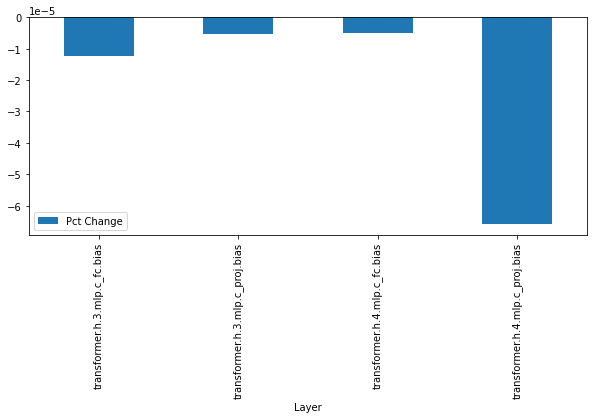

In [57]:
df.loc[df.Layer.apply(lambda x: "mlp" in x)].set_index("Layer").plot(kind='bar')

In [73]:
model, tokenizer = utils.loadTrainedModel("../models/model_epoch0_ts10000.20210314.16.03.1615740151")


In [102]:
model_ots, _ = utils.loadOTSModel()

In [107]:
from collections import defaultdict

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
def vizChange(model): 
    model.to(DEVICE)
    
    change_map = defaultdict(list)

    dataloader = retrieveDataloader(tokenizer, bs=1, dataset='valid', max_obs=100)
    model.train()
    for train_step, (lm_data, edit_example, ent) in enumerate(dataloader):

        edit_tokens, edit_mask = edit_example
        ent_tokens = ent[0].flatten() #1d array of vocab indexes
        ent_tokens = ent_tokens[ent_tokens != 50256]
        edit_locs = utils.locateEntityEdit(edit_tokens, ent_tokens)


        edit_labels = torch.zeros(edit_tokens.shape, dtype=torch.long) - 100
        edit_labels[:, edit_locs] = edit_tokens[:, edit_locs]
        edit_labels = edit_labels.to(DEVICE)
        edit_tokens, edit_mask = edit_tokens.to(DEVICE), edit_mask.to(DEVICE)


        inner_opt = torch.optim.SGD(model.transformer.h[-3:].parameters(), lr=1e-3)
        with higher.innerloop_ctx(
            model, 
            inner_opt, 
            copy_initial_weights=False, 
            track_higher_grads=True
            ) as (fmodel, diffopt):


            loss = fmodel(
                edit_tokens, 
                attention_mask=edit_mask,
                labels=edit_labels
            ).loss
            diffopt.step(loss)


            for (p_name, p_), fp in zip(model.named_parameters(), fmodel.parameters()):
                if p_name[:15] in [f"transformer.h.{i}" for i in range(3,6)]:
                    pct_change = (torch.linalg.norm(p_) - torch.linalg.norm(fp)) / torch.linalg.norm(p_)
                    change_map['run'].append(train_step)
                    change_map['layer'].append(p_name)
                    change_map['change'].append(pct_change.item())

        if train_step > 50:
            break
    return change_map

In [111]:
change_trained = pd.DataFrame(vizChange(model))
change_ots = pd.DataFrame(vizChange(model_ots))

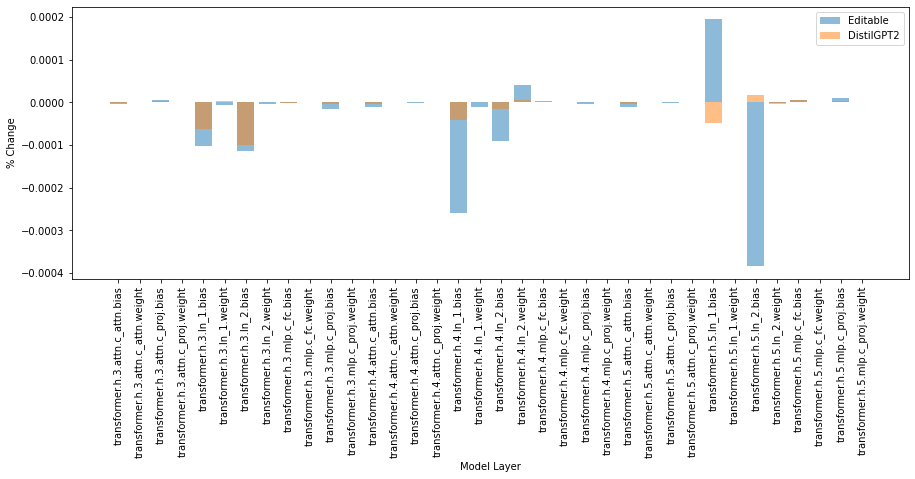

In [135]:
plt.bar((change_trained
#          .loc[df.layer.apply(lambda x: 'mlp' in x)]
        .groupby('layer')
        .change.mean().reset_index().layer),
        (change_trained
#         .loc[df.layer.apply(lambda x: 'mlp' in x)]                                     
        .groupby('layer')
        .change.mean().reset_index().change), alpha=0.5, label='Editable')

plt.bar((change_ots
#          .loc[df.layer.apply(lambda x: 'mlp' in x)]
        .groupby('layer')
        .change.mean().reset_index().layer),
        (change_ots
#         .loc[df.layer.apply(lambda x: 'mlp' in x)]
        .groupby('layer')
        .change.mean().reset_index().change), alpha=0.5, label='DistilGPT2')

plt.legend()
plt.xticks(rotation='vertical')
plt.ylabel("% Change")
plt.xlabel("Model Layer")
plt.show()

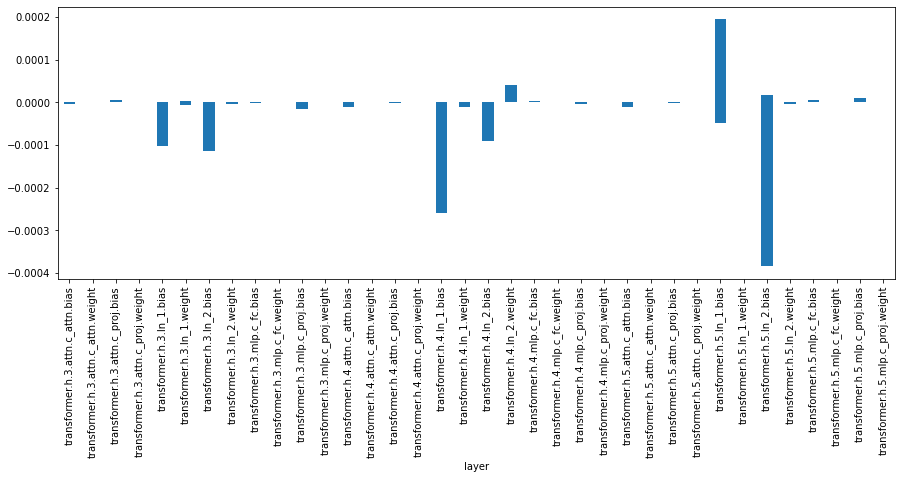

In [114]:
matplotlib.rcParams['figure.figsize'] = (15, 5)

for df in [change_trained, change_ots]:
    (
        df
    #     .loc[df.layer.apply(lambda x: 'mlp' in x)]
        .groupby('layer')

        .change.mean().plot(kind='bar')

    )
plt.show()

In [97]:
df.layer.unique()

array(['transformer.h.3.ln_1.weight', 'transformer.h.3.ln_1.bias',
       'transformer.h.3.attn.c_attn.weight',
       'transformer.h.3.attn.c_attn.bias',
       'transformer.h.3.attn.c_proj.weight',
       'transformer.h.3.attn.c_proj.bias', 'transformer.h.3.ln_2.weight',
       'transformer.h.3.ln_2.bias', 'transformer.h.3.mlp.c_fc.weight',
       'transformer.h.3.mlp.c_fc.bias',
       'transformer.h.3.mlp.c_proj.weight',
       'transformer.h.3.mlp.c_proj.bias', 'transformer.h.4.ln_1.weight',
       'transformer.h.4.ln_1.bias', 'transformer.h.4.attn.c_attn.weight',
       'transformer.h.4.attn.c_attn.bias',
       'transformer.h.4.attn.c_proj.weight',
       'transformer.h.4.attn.c_proj.bias', 'transformer.h.4.ln_2.weight',
       'transformer.h.4.ln_2.bias', 'transformer.h.4.mlp.c_fc.weight',
       'transformer.h.4.mlp.c_fc.bias',
       'transformer.h.4.mlp.c_proj.weight',
       'transformer.h.4.mlp.c_proj.bias', 'transformer.h.5.ln_1.weight',
       'transformer.h.5.ln_1.bias'

<AxesSubplot:ylabel='Frequency'>

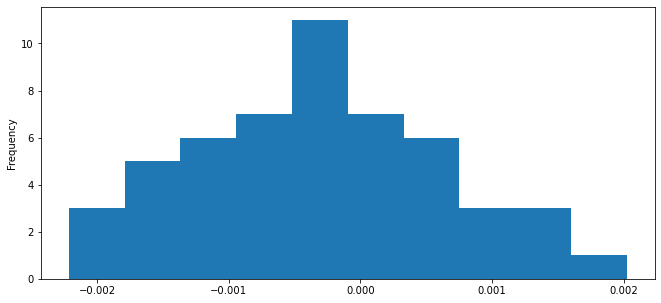

In [98]:
(
    df.loc[df.layer == 'transformer.h.5.ln_2.bias']
    .change.plot(kind='hist')
    
)